In [1]:
import numpy as np 
import pandas as pd
import os
import time
import datetime
import logging
import matplotlib.pyplot as plt

loggers = {}

def get_logger(name):
    
    global loggers

    if loggers.get(name):
        return loggers.get(name)
    else:
        logger = logging.getLogger(name)
        logger.setLevel(logging.DEBUG)
        now = datetime.datetime.now()
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        loggers[name] = logger
        return logger
    
logger = get_logger('IndeedLogger')

In [2]:
def load_data():
    train_feats_filename =  './train_features.csv'
    train_tgt_filename   =  './train_salaries.csv'
    test_feats_filename  =  './test_features.csv'

    train_feats_raw = pd.read_csv(train_feats_filename, delimiter=",")
    train_tgt       = pd.read_csv(train_tgt_filename, delimiter=",")
    test_raw        = pd.read_csv(test_feats_filename, delimiter=",")
    train_raw       = train_feats_raw.join(train_tgt.set_index(['jobId']), on=['jobId'])
    logger.info('Train and test data loaded....')
    return train_raw, test_raw

def visualize_data(df):
    logger.info('Starting visualise training data....')
    df1 = df.groupby('industry')['salary'].agg('median').sort_values().reset_index()
    df2 = df.groupby(['major'])['salary'].agg('median').sort_values().reset_index()
    df3 = df.groupby(['yearsExperience'])['salary'].agg('median').sort_values().reset_index()
    df4 = df.groupby(['milesFromMetropolis'])['salary'].agg('median').sort_values().reset_index()

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35,25))
    df1.plot(ax=axes[0,0],x='industry', y='salary', kind="barh",  color='b', title="Median Salary by Industry")
    df2.plot(ax=axes[0,1],x='major', y='salary', kind="barh", color='b', title="Median Salary by Major")
    df4.plot(ax=axes[1,0],x='milesFromMetropolis', y='salary', kind="barh", color='b', title="Median Salary by Miles away")
    df3.plot(ax=axes[1,1],x='yearsExperience', y='salary', kind="barh", color='b', title="Median Salary by Experience")

    plt.show()

In [3]:
train_raw, test_raw = load_data()  
train_raw.head()

2018-12-03 09:55:59,456 INFO Train and test data loaded....


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


2018-12-03 09:55:59,542 INFO Starting visualise training data....


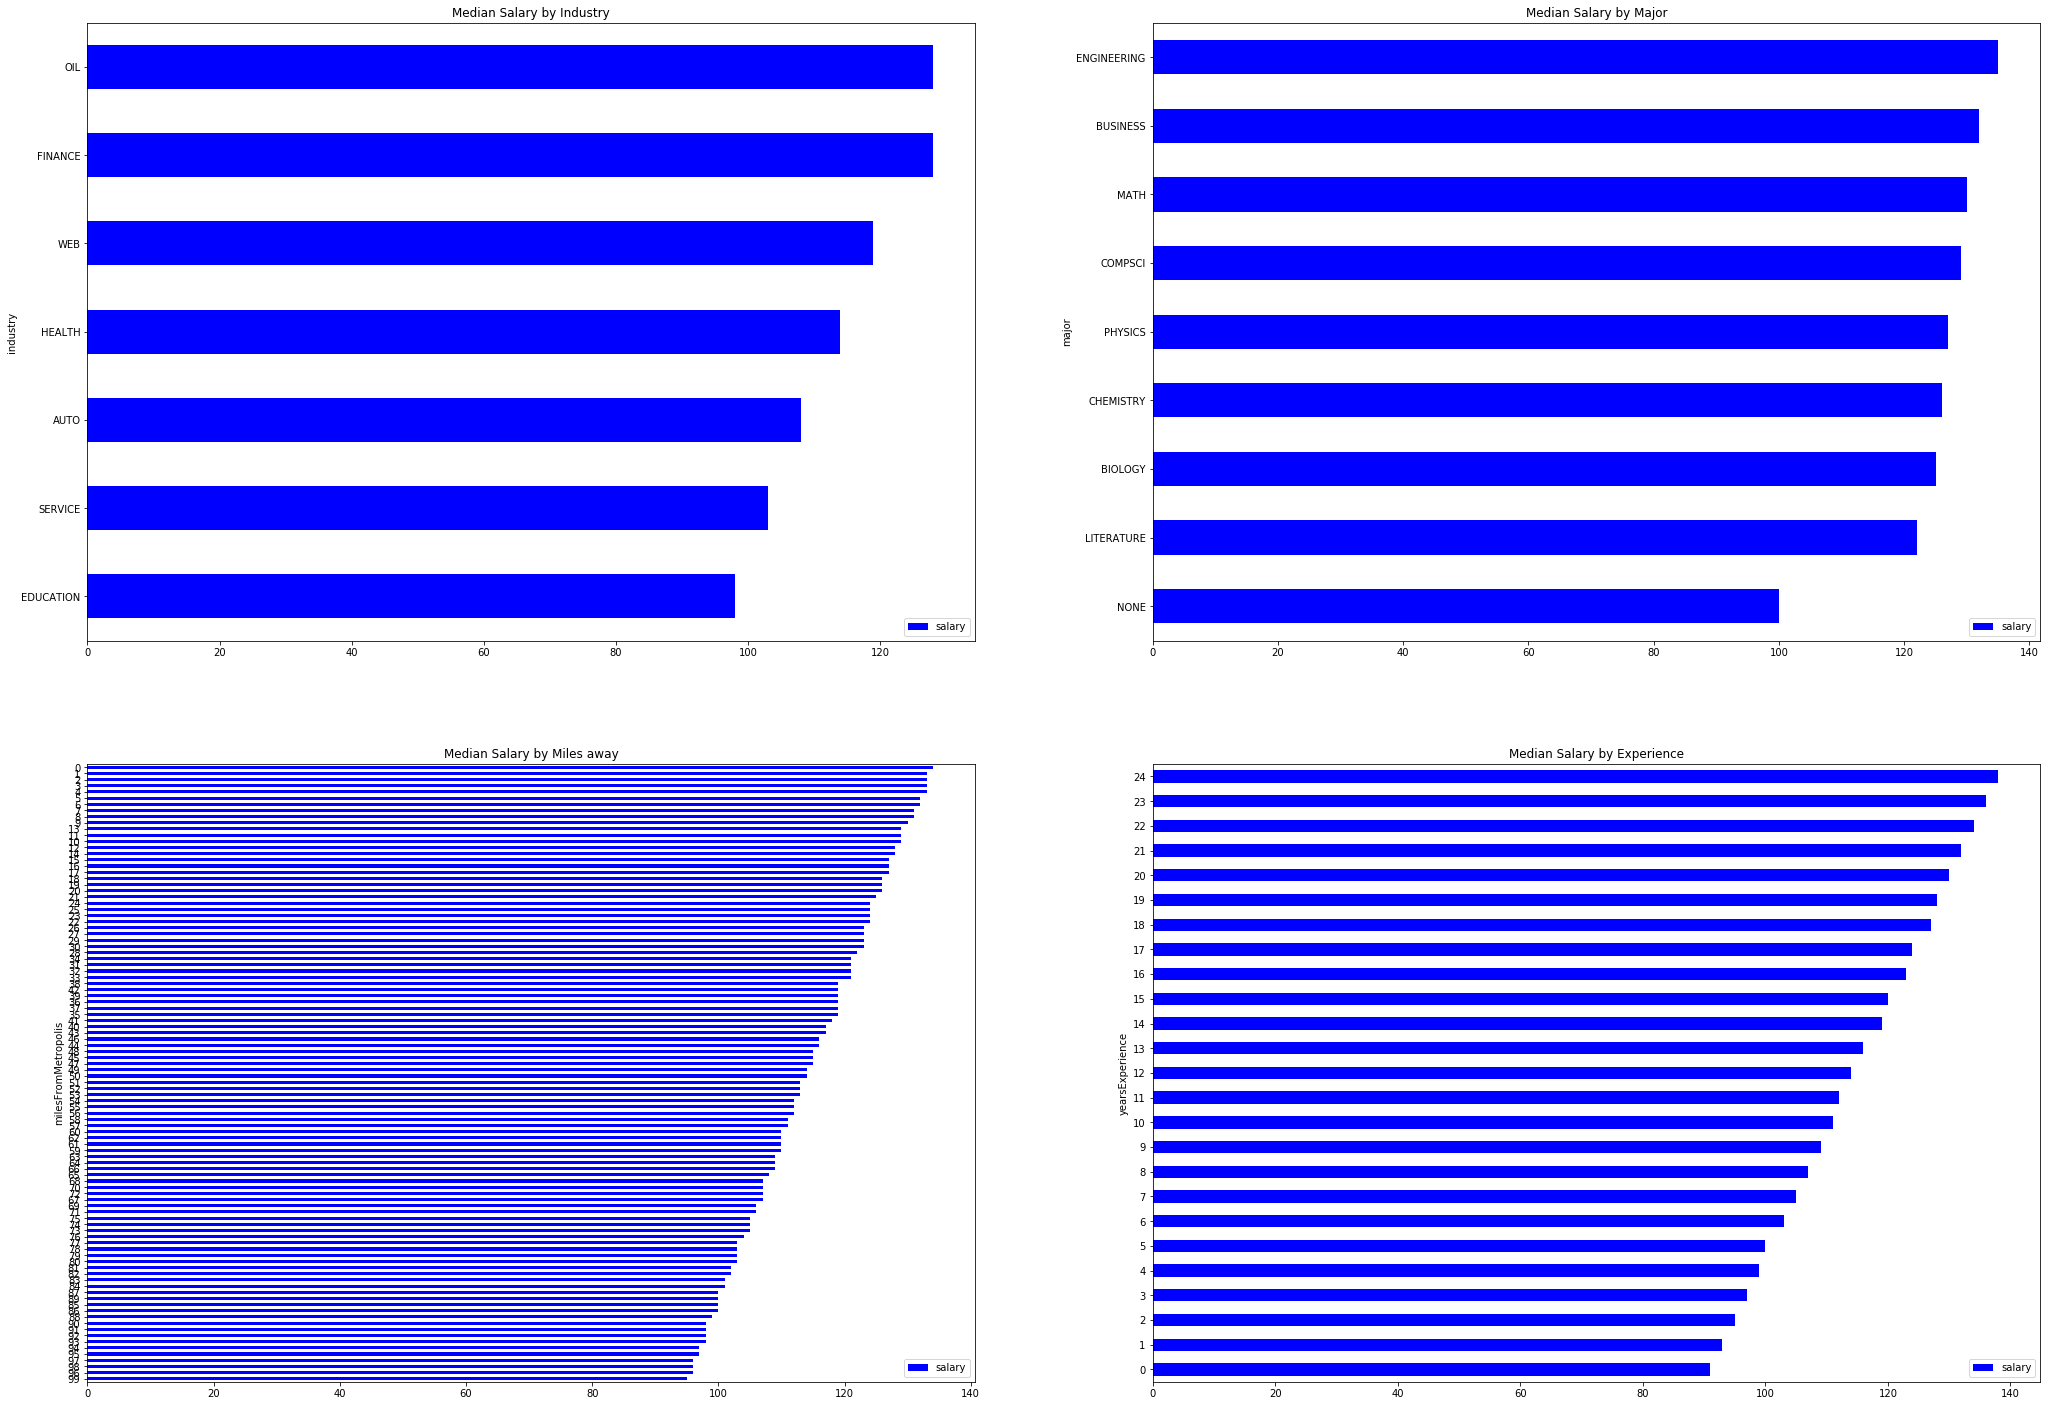

In [4]:
visualize_data(train_raw)

<h4> 
The plots above show us the how predictive the values of each these features in isolation, now we have to find out the optimum combination of these features that best predicts the salary 

Inferences:
<ul>    
    <li> Miles from metropolis negatively correlates with median Salaries </li>
    <li> OIL by industry and Engineering by Major yeilds the best median (btw not mean) salary </li>
</ul>
</h4>

In [5]:
def preprocess_data(df,train=True):
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import LabelEncoder
    from sklearn_pandas import DataFrameMapper
    
    # All cat featurs need encoding
    # Label Encoding and 1-Hot Encoding gave same performances with negligble differences in the final models
    # So, I thought no point in exploding the feature space by doing 1-Hot encoding
    # Scaling the numeric features didnt help lift the performance
    
    if train:
        logger.info('Starting to preprocess train data....')
        mapper = DataFrameMapper([
             (u'jobId', None),
             (u'companyId', LabelEncoder()),
             (u'jobType', LabelEncoder()),
             (u'degree', LabelEncoder()),     
             (u'major',LabelEncoder()),
             (u'industry', LabelEncoder()),
             ([u'yearsExperience'], None),
             ([u'milesFromMetropolis'], None),
             (u'salary', None)
         ], df_out=True)
        df = mapper.fit_transform(df)
        logger.info('Train data preprocessing done')
        
    else:
        logger.info('Starting to preprocess test data....')
        mapper = DataFrameMapper([
             (u'jobId', None),
             (u'companyId', LabelEncoder()),
             (u'jobType', LabelEncoder()),
             (u'degree', LabelEncoder()),     
             (u'major',LabelEncoder()),
             (u'industry', LabelEncoder()),
             ([u'yearsExperience'], None),
             ([u'milesFromMetropolis'], None)
         ], df_out=True)
        df = mapper.fit_transform(df)
        logger.info('Test data preprocessing done')
    
    return df

In [6]:
train_raw = preprocess_data(train_raw)
test_raw  = preprocess_data(test_raw, False)

2018-12-03 09:56:01,689 INFO Starting to preprocess train data....
2018-12-03 09:56:10,260 INFO Train data preprocessing done
2018-12-03 09:56:10,263 INFO Starting to preprocess test data....
2018-12-03 09:56:18,333 INFO Test data preprocessing done


In [7]:
# I am a fan of David Wolpert's "No Free Lunch Theorem" for ML: 
# "state[s] that any two optimization algorithms are equivalent when their performance is averaged across all possible problems"
# So let's walk thru a couple of algorithms, One Linear mathematical model (and its variants), One Tree based model, One Ensemble model

def explore_models():
    
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Ridge
    from sklearn.linear_model import Lasso
    from sklearn.linear_model import ElasticNet
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold


    models = []
    models.append(( "LR RMSE" , LinearRegression()))
    models.append(( "RR RMSE" , Ridge()))   
    models.append(( "LAR RMSE" , Lasso()))
    models.append(( "EN RMSE" , ElasticNet()))
    models.append(( "CART RMSE" , DecisionTreeRegressor()))
    models.append(( "RandomForest RMSE" , RandomForestRegressor()))

    results = []
    names = []
    scoring =  'neg_mean_squared_error'
    logger.info('Starting to explore models....')
    for name, model in models:
      kfold = KFold(n_splits=7, random_state=7)
      cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, (cv_results.mean() * -1) ** 0.5, cv_results.std())
      logger.info(msg)
    logger.info('Model exploration done')    
        

In [8]:
X = train_raw[train_raw.columns.tolist()]
X.drop(['jobId','salary'], inplace=True, axis=1)
y = train_raw.salary.values

# Making the train/val/test slices out of the training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
explore_models()


2018-12-03 09:56:18,779 INFO Starting to explore models....
2018-12-03 09:56:19,559 INFO LR RMSE: 30.429704 (2.210604)
2018-12-03 09:56:20,247 INFO RR RMSE: 30.429704 (2.210604)
2018-12-03 09:56:21,118 INFO LAR RMSE: 30.446324 (2.256159)
2018-12-03 09:56:22,147 INFO EN RMSE: 30.495265 (2.341882)
2018-12-03 09:56:37,304 INFO CART RMSE: 27.651849 (3.762112)
2018-12-03 09:58:17,089 INFO RandomForest RMSE: 21.086193 (1.279109)
2018-12-03 09:58:17,090 INFO Model exploration done


<h4> Here are some inferences </h4>
<ul>
        <li> Model exploration suggests a Tree based model or more precisely a tree based boosting ensemble has a better shot at this dataset.</li>
        <li>A RandomForestRegressor w/default hyperparameters toping this list, hints that combining multiple weak trees can boost the score.</li>
        <li>Let's try a gradient boosting implementation like LightGBM, because</li>
        <li>The GBM progression looked something like this <b> GBM < XGBOOST < LightGBM </b> </li>
        <li>Yandex CatBoost sounds promising as well </li>
    
</ul>

In [9]:
import lightgbm as lgb

def get_lgb_model():
    # Just using the Hyper-parameters without much tuning, most of them with default values
    lgb_params = {
                'learning_rate': 0.03,
                'num_leaves': 31,
                'metric': ('rmse'),
                'early_stopping_rounds': 5,
                'max_bin' : 255
     }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_val, y_val, reference=lgb_train)
    evals_result ={}
    logger.info('Starting to train..')    
    lgbm = lgb.train(lgb_params,
                    lgb_train,
                    num_boost_round = 1000,
                    valid_sets=[lgb_train, lgb_test],
                    evals_result=evals_result,
                    verbose_eval=1)
    
    logger.info('Training done')
    return lgbm, evals_result

lgbm, evals_result = get_lgb_model()

2018-12-03 09:58:17,129 INFO Starting to train..
/anaconda2/lib/python2.7/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
2018-12-03 09:58:35,629 INFO Training done


[1]	training's rmse: 38.0965	valid_1's rmse: 37.9281
Training until validation scores don't improve for 5 rounds.
[2]	training's rmse: 37.4674	valid_1's rmse: 37.2998
[3]	training's rmse: 36.8642	valid_1's rmse: 36.6973
[4]	training's rmse: 36.2873	valid_1's rmse: 36.1209
[5]	training's rmse: 35.7265	valid_1's rmse: 35.5613
[6]	training's rmse: 35.1929	valid_1's rmse: 35.0285
[7]	training's rmse: 34.6761	valid_1's rmse: 34.5127
[8]	training's rmse: 34.1852	valid_1's rmse: 34.0232
[9]	training's rmse: 33.7089	valid_1's rmse: 33.5484
[10]	training's rmse: 33.2552	valid_1's rmse: 33.0953
[11]	training's rmse: 32.8171	valid_1's rmse: 32.6584
[12]	training's rmse: 32.3848	valid_1's rmse: 32.2276
[13]	training's rmse: 31.9804	valid_1's rmse: 31.825
[14]	training's rmse: 31.5893	valid_1's rmse: 31.4356
[15]	training's rmse: 31.2141	valid_1's rmse: 31.0617
[16]	training's rmse: 30.8449	valid_1's rmse: 30.6939
[17]	training's rmse: 30.4971	valid_1's rmse: 30.3472
[18]	training's rmse: 30.1568	v

2018-12-03 09:58:35,673 INFO Plotting training and validation RMSE recorded during training over several models...


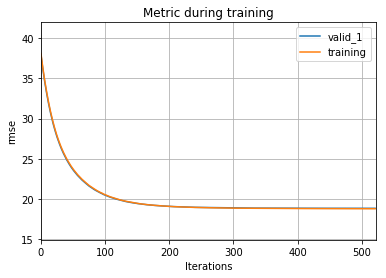

2018-12-03 09:58:35,831 INFO Predicting on the 'test slice' carved out from the Training set
2018-12-03 09:58:38,731 INFO The RMSE is: 18.867854766366104


In [10]:
ax = lgb.plot_metric(evals_result, metric='rmse')
logger.info('Plotting training and validation RMSE recorded during training over several models...')
plt.show()
from sklearn.metrics import mean_squared_error
logger.info("Predicting on the 'test slice' carved out from the Training set")
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)
logger.info("The RMSE is: " + str(mean_squared_error(y_test, y_pred) ** 0.5)) 

2018-12-03 09:58:38,744 INFO Plotting feature importances...


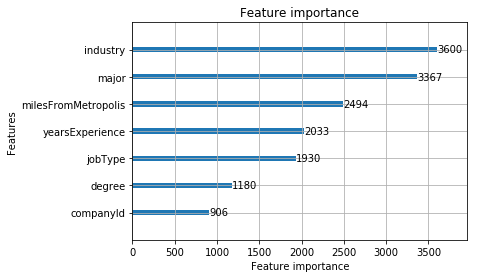

In [11]:
logger.info('Plotting feature importances...')
ax = lgb.plot_importance(lgbm, max_num_features=7)
plt.show()

In [12]:
Test_X = test_raw[test_raw.columns.tolist()]
Test_X.drop(['jobId'], inplace=True, axis=1)
Test_Jobids = test_raw.jobId.values

from sklearn.metrics import mean_squared_error
logger.info("Making final predictions on the actual Test set")
Test_y = lgbm.predict(Test_X, num_iteration=lgbm.best_iteration)
# Rounding the salaries
Test_y = map(int, np.rint(Test_y)) 
submission = pd.DataFrame({'jobId':Test_Jobids,'salary': Test_y})
submission.to_csv('PD_test_salaries.csv', index=False)
logger.info("All done !!")

2018-12-03 09:58:39,066 INFO Making final predictions on the actual Test set
2018-12-03 09:58:55,091 INFO All done !!


In [5]:
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='PrithiviDa', api_key='S0rzpXS10xpMOafvpRQD')

import plotly.graph_objs as go

trace0 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[10, 15, 13, 17]
)
trace1 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[16, 5, 11, 9]
)
data = [trace0, trace1]

#py.plot(data, filename = 'basic-line', auto_open=True)
py.iplot(data, filename = 'basic-line')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~PrithiviDa/0 or inside your plot.ly account where it is named 'basic-line'
